In [20]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd

df = pd.read_pickle('/home/jxm3/research/prompting/interpretable-autoprompting/results_icml/df_prompts_and_reciprocal_rank.pkl')

In [3]:
df['task_name'].value_counts()

task1146_country_capital     57
add_two                      48
task1147_country_currency    46
translation_en-es            44
divide_two                   44
                             ..
d3_1                         18
d3_7                         18
d3_47                        17
d3_44                        17
d3_50                        15
Name: task_name, Length: 98, dtype: int64

In [4]:
df['model_cls'].value_counts()

suff          1360
autoprompt     692
iprompt        659
Name: model_cls, dtype: int64

In [5]:
df['checkpoint'].value_counts()

EleutherAI/gpt-j-6B        1327
facebook/galactica-6.7b     794
google/flan-t5-xl           590
Name: checkpoint, dtype: int64

In [6]:
MATH_TASK_NAMES = {
    'add_two', 'multiply_two', 'subtract_two', 'max_two', 
    'first_two', 'square_one', 'double_one', 'exp_one',  
    'fibonacci_one', 'divide_two'
}
ANLI_TASK_NAMES = {'task088_identify_typo_verification',
 'task092_check_prime_classification',
 'task107_splash_question_to_sql',
 'task1146_country_capital',
 'task1147_country_currency',
 'task1149_item_check_edible',
 'task1191_food_veg_nonveg',
 'task1336_peixian_equity_evaluation_corpus_gender_classifier',
 'task1509_evalution_antonyms',
 'task183_rhyme_generation'}

gpt_df = df[
       (df['task_name'].map(lambda t: (t in MATH_TASK_NAMES) or (t in ANLI_TASK_NAMES)))
    &  (df['checkpoint'] == 'EleutherAI/gpt-j-6B')
    &  (df['model_cls'] == 'iprompt')
]
len(gpt_df)

60

## getting accuraciesfrom iprompt import prompt_classification

model = prompt_classification.create_model(r['checkpoint'].unique()[0])

In [8]:
from iprompt import prompt_classification

model = prompt_classification.create_model(gpt_df['checkpoint'].unique()[0])

In [75]:
## Compute accuracy given correct prompt and save for each task.
from tqdm.notebook import tqdm
from iprompt.data import get_data

data = []
print('calculating accs...')
n_shots = 1
batch_size = 32

"""
task_name: str = 'add_two',
 n_shots: int = 1,
 train_split_frac: float = None,
 max_dset_size: int = 10000,
 template_num_task_phrasing: int = 0,
 max_digit: int = 10,
 """

USE_MULTI_TOKEN = False
RESTRICT_TO_VALID_ANSWERS = False

for _, output in tqdm(gpt_df.iterrows(), total=len(gpt_df)):
    (dset, dset_test), check_answer_func, descr = get_data(
        output['task_name'], n_shots=1, train_split_frac=1.0,
        max_dset_size=1000, template_num_task_phrasing=0,
        max_digit=10,
    )
    print(output['task_name'], f'dset of len {len(dset)} (max_digit={10})')
    # if task_name == 'task107_splash_question_to_sql':
    #     batch_size = max(1, batch_size//4)
    ####   No prompt  ####
    noprompt_likelihood, noprompt_loss, noprompt_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix="", multi_token=USE_MULTI_TOKEN, verbose=False,
        batch_size=batch_size, restrict_to_valid_answers=RESTRICT_TO_VALID_ANSWERS,
    )
    ####   Manual prompt  ####
    manual_likelihood, manual_loss, manual_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=descr, multi_token=USE_MULTI_TOKEN, verbose=False,
        batch_size=batch_size, restrict_to_valid_answers=RESTRICT_TO_VALID_ANSWERS,
    )
    ####   iPrompt prompt   ####
    iprompt_likelihood, iprompt_loss, iprompt_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=output['prefixes'], multi_token=USE_MULTI_TOKEN, verbose=False,
        batch_size=batch_size, restrict_to_valid_answers=RESTRICT_TO_VALID_ANSWERS,
    )
    print(f'>\tnoprompt acc: {noprompt_acc} // \t manual acc: {manual_acc} // \t iprompt acc: {iprompt_acc} // manual likelihood {manual_likelihood}')
    ####
    output['noprompt_likelihood'] = noprompt_likelihood
    output['noprompt_loss'] = noprompt_loss
    output['noprompt_acc'] = noprompt_acc
    #     
    output['manual_likelihood'] = manual_likelihood
    output['manual_loss'] = manual_loss
    output['manual_acc'] = manual_acc
    #
    output['iprompt_likelihood'] = iprompt_likelihood
    output['iprompt_loss'] = iprompt_loss
    output['iprompt_acc'] = iprompt_acc
    data.append(output)

calculating accs...


  0%|          | 0/60 [00:00<?, ?it/s]

task1146_country_capital dset of len 231 (max_digit=10)
>	noprompt acc: 4.329004329004329 // 	 manual acc: 70.99567099567099 // 	 iprompt acc: 56.277056277056275 // manual likelihood 0.5582367888776771
add_two dset of len 100 (max_digit=10)
>	noprompt acc: 13.0 // 	 manual acc: 73.0 // 	 iprompt acc: 71.0 // manual likelihood 0.35510615587234495
task1147_country_currency dset of len 232 (max_digit=10)
>	noprompt acc: 27.586206896551722 // 	 manual acc: 23.275862068965516 // 	 iprompt acc: 40.08620689655172 // manual likelihood 0.07636292689833148
multiply_two dset of len 100 (max_digit=10)
>	noprompt acc: 20.0 // 	 manual acc: 65.0 // 	 iprompt acc: 61.0 // manual likelihood 0.3190463310480118
task1509_evalution_antonyms dset of len 551 (max_digit=10)
>	noprompt acc: 3.266787658802178 // 	 manual acc: 24.319419237749546 // 	 iprompt acc: 16.515426497277677 // manual likelihood 0.13738053961371338
subtract_two dset of len 100 (max_digit=10)
>	noprompt acc: 12.0 // 	 manual acc: 47.0 // 

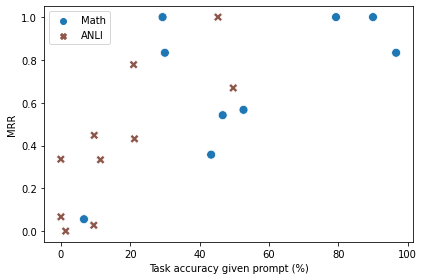

In [91]:
default_top_prompts = pd.DataFrame(data)
default_top_prompts.to_pickle('/home/jxm3/research/prompting/interpretable-autoprompting/results_icml/df_prompts_and_reciprocal_rank_default_with_accs.pkl')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = default_top_prompts.groupby('task_name').mean().reset_index()
df['manual_log_likelihood'] = np.log(df['manual_likelihood'].to_numpy())
df['is_math'] = df['task_name'].map(lambda tn: tn in MATH_TASK_NAMES)
COLORS = sns.color_palette()

df = df[df['task_name'] != 'divide_two']
df['nmanual_loss'] = df['manual_loss'] * -1

df['task_group'] = df['is_math'].map(lambda im: ['ANLI', 'Math'][im])

ax = sns.scatterplot(data=df, y='reciprocal_rank', x='iprompt_acc', hue='task_group', palette=[COLORS[0], COLORS[5]], s=80, style='task_group')
ax.set_ylabel('MRR')
ax.set_xlabel('Task accuracy given prompt (%)')

# Remove legend title
ax.legend_.set_title(None)

# ax.set_yscale('log')
for i in range(len(df)):
    txt, y, x = (
        df.iloc[i]["task_name"],
        df.iloc[i]["manual_likelihood"],
        df.iloc[i]["reciprocal_rank"]
    )
    color = COLORS[0] if (txt in MATH_TASK_NAMES) else COLORS[6]
    # txt = "xx"
    # ax.annotate(txt, (x, y), fontsize=8, weight="normal", alpha=0.9, color=color, family="monospace")


# Save
pdf_filename = 'ablation_acc_vs_mrr.pdf'
plt.tight_layout()
plt.savefig(pdf_filename, dpi=300)